# Posterior Estimation With Multimodal Data

_Author: Valentin Pratz_

Observed data can come in many forms, like single observations, multiple _exchangeable_ observations or time series.
A fusion network can combine all those forms into a joint learned summary space, by combining the outputs of different specialized summary networks.
This requires some pre-processing steps, which we will demonstrate in this tutorial.

## Toy Problem

We will construct a simple toy problem, in which we have to determine the mean $\mu$ and the standard deviation $\sigma$ of a two-dimensional Gaussian distribution. For this, we simulate data from two experiments:

- Experiment A: `n_exchangeable` exchangeable samples from the distribution.
- Experiment B: A time series of the cumulative sum of `n_time_series` draws from the distribution.

Both experiments will share the parameters $\mu$ and $\sigma$.

In [1]:
import bayesflow as bf
import keras
import numpy as np
import matplotlib.pyplot as plt

2025-05-13 07:49:10.696605: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747122550.709248  184063 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747122550.713174  184063 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-13 07:49:10.727103: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-13 07:49:12.936919: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL

In [2]:
rng = np.random.default_rng(2025)


def prior():
    return {"mu": rng.normal(size=2), "sigma": rng.gamma(5, 0.1)}

In [3]:
def likelihood_a(mu, sigma, n_exchangeable=5):
    return {"observables_a": rng.normal(mu, sigma, size=(n_exchangeable, 2))}


def likelihood_b(mu, sigma, n_time_series=20, **kwargs):
    return {
        "observables_b": np.cumsum(
            rng.normal(mu, sigma, size=(n_time_series, 2)), axis=0
        ),
        "time_b": np.linspace(0.0, 1.0, n_time_series)[:, None],
    }

We construct a simulator from the prior and the likelihoods in the usual way.

In [4]:
simulator = bf.make_simulator([prior, likelihood_a, likelihood_b])

We can simulate and visualize a few example datasets:

In [5]:
n_examples = 3
data = simulator.sample(n_examples)

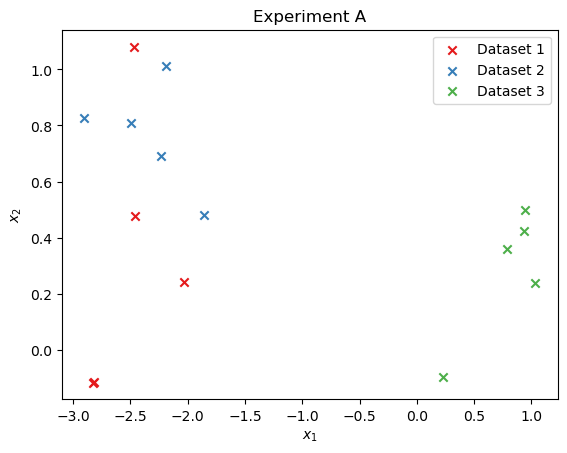

In [6]:
cmap = plt.cm.Set1
for i in range(n_examples):
    plt.scatter(
        data["observables_a"][i, :, 0],
        data["observables_a"][i, :, 1],
        marker="x",
        color=cmap(i),
        label=f"Dataset {i+1}",
    )
plt.title("Experiment A")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend();

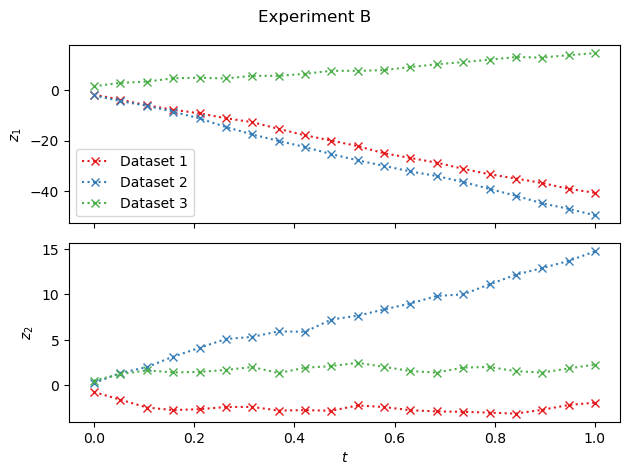

In [7]:
fig, axs = plt.subplots(2, 1, sharex=True)
for i in range(n_examples):
    for j in range(2):
        axs[j].plot(
            data["time_b"][i, :, 0].T,
            data["observables_b"][i, :, j].T,
            marker="x",
            color=cmap(i),
            linestyle="dotted",
            label=f"Dataset {i+1}",
        )
        axs[j].set(ylabel=f"$z_{j+1}$")
axs[0].legend()
axs[1].set(xlabel="$t$")
fig.suptitle("Experiment B")
fig.tight_layout();

## Summary Networks

We start by setting up the individual summary networks, which will be the _backbones_ of the fusion network. For Experiment A, we use a `SetTransformer`, which is constructed for exchangeable observations. For Experiment B, we use a `TimeSeriesTransformer`, which is designed to handle time series data. For the latter, we set `time_axis=-1`, indicating that we will concatenate the time to the data at the end of the vector. We will do this below using the adapter.

In [8]:
summary_network_a = bf.networks.SetTransformer(summary_dim=6)
summary_network_b = bf.networks.TimeSeriesTransformer(summary_dim=6, time_axis=-1)

To combine the outputs of both networks, we define another neural network, the _head_. It will get the concatenated outputs of our summary networks as inputs.

In [9]:
summary_dim = 6
head = keras.Sequential(
    [bf.networks.MLP(widths=[128, 128]), keras.layers.Dense(summary_dim)]
)

Now, pass all the the networks to the `FusionNetwork`. We use a dictionary for the summary networks, so that we can specify which input belongs to which summary network. The keys can be chosen arbitrarily, here we use `input_a` and `input_b`.

In [10]:
summary_network = bf.networks.FusionNetwork(
    backbones={"input_a": summary_network_a, "input_b": summary_network_b},
    head=head,
)

## Pre-processing with the Adapter

We now have to transform the simulator outputs to the structure required by BayesFlow:

- the parameter vector goes to `inference_variables`
- the inputs to the summary networks go to `summary_variables`

As we now have multiple simulator outputs with incompatible shapes, `summary_variables` has to be a dictionary with the keys we used above for the summary networks.
So it should have the contents:

- `input_a`: pre-processed oberservations from Experiment A that are passed to the `SetTransformer`
- `input_b`: pre-processed oberservations from Experiment B that are passed to the `TimeSeriesTransformer`

Note that most transforms in the adapter cannot handle nested structures (i.e., dicts) for now, so we have to create the `summary_variables` dictionary after all pre-processing has been done.

The simulator outputs variables with the following shapes (3 is the batch dimension):

In [11]:
print(keras.tree.map_structure(keras.ops.shape, data))

{'mu': (3, 2), 'sigma': (3, 1), 'observables_a': (3, 5, 2), 'observables_b': (3, 20, 2), 'time_b': (3, 20, 1)}


In [12]:
adapter = (
    bf.adapters.Adapter.create_default(["mu", "sigma"])
    .rename("observables_a", "input_a")
    .concatenate(["observables_b", "time_b"], into="input_b")
    .standardize()
    .group(
        ["input_a", "input_b"], into="summary_variables"
    )  # this transform should go last
)

The adapter produces the following output, just as we expect it:

In [13]:
print(keras.tree.map_structure(keras.ops.shape, adapter(data)))

{'inference_variables': (3, 3), 'summary_variables': {'input_a': (3, 5, 2), 'input_b': (3, 20, 3)}}


## Training

We have a summary network and the appropriate adapter, which are the two parts in our pipeline that are different for multimodal problems. From now on, the pipeline works as in any other BayesFlow workflow.

In [14]:
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    summary_network=summary_network,
)

In [15]:
history = workflow.fit_online(epochs=50, validation_data=64)

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - loss: 5.0165 - loss/inference_loss: 5.0165 - val_loss: 1.6103 - val_loss/inference_loss: 1.6103
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 1.5016 - loss/inference_loss: 1.5016 - val_loss: 0.7603 - val_loss/inference_loss: 0.7603
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 1.0897 - loss/inference_loss: 1.0897 - val_loss: 0.1796 - val_loss/inference_loss: 0.1796
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.8483 - loss/inference_loss: 0.8483 - val_loss: 0.3936 - val_loss/inference_loss: 0.3936
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.7241 - loss/inference_loss: 0.7241 - val_loss: -0.2675 - val_loss/inference_loss: -0.2675
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.5956 - loss/inference_loss: 0.5956 - val_loss: 0.2622 - val_loss/inference_loss: 0.2622
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.5266 - loss/inference_loss: 

## Evaluation

We plot the default diagnostic to assess whether training has been successful. Please refer to the introductory notebooks for details on the interpretation.

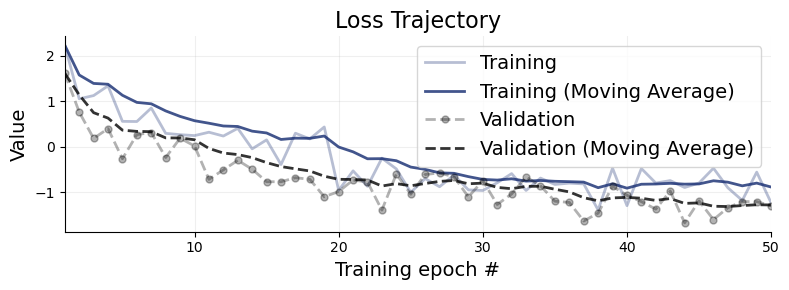

In [29]:
bf.diagnostics.plots.loss(history, figsize=(8, 3));

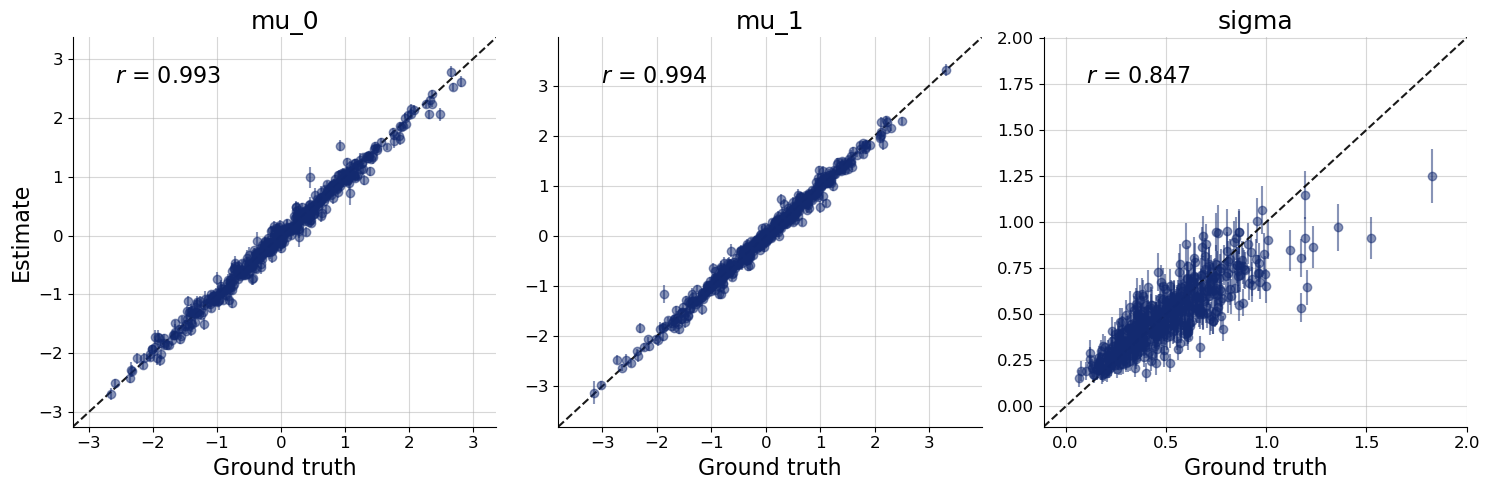

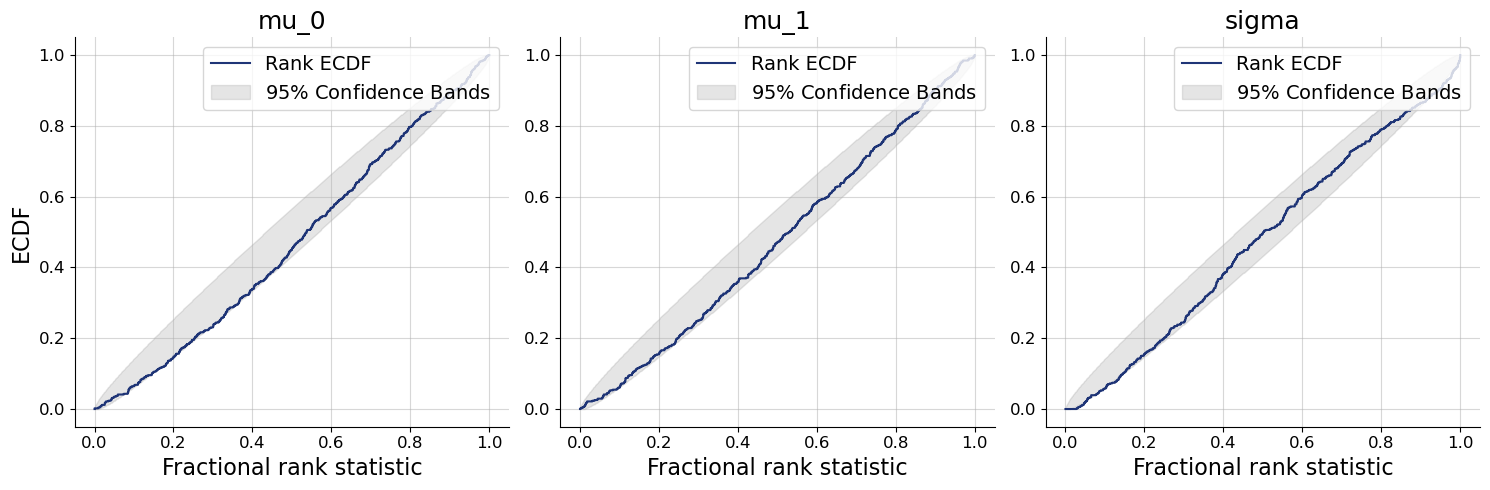

In [33]:
workflow.plot_custom_diagnostics(
    512,
    plot_fns={
        "recovery": bf.diagnostics.plots.recovery,
        "calibration_ecdf": bf.diagnostics.plots.calibration_ecdf,
    },
);